In [2]:
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class_map = {"Happy": 0,
             "Sad": 1,
             "Surprised": 2,
             "Mad": 3}
NUM_CLASSES = 4

# You may have to change these two
n_epochs = 10000
batch_size = 256
IMAGE_SHAPE = 32 # Images will be reshaped to IMAGE_SHAPE x IMAGE_SHAPE
NUM_PIXEL_CHANNELS = 3
INPUT_SHAPE = (IMAGE_SHAPE, IMAGE_SHAPE, NUM_PIXEL_CHANNELS)
LATENT_DIM = 100


if False:
    # Set seeds for reproducibility
    SEED = 2024
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)


gpus = tf.config.experimental.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("GPU(s) available.")
else:
    print("No GPU(s) available.")

PLOT_SETTINGS = {"text.usetex": True,
                 "font.family": "serif",
                 "figure.figsize": (8.0, 6.0),
                 "font.size": 16,
                 "axes.labelsize": 16,
                 "legend.fontsize": 14,
                 "xtick.labelsize": 14,
                 "ytick.labelsize": 14,
                 "axes.titlesize": 24,
                 "lines.linewidth": 2.0,
                 }
plt.rcParams.update(PLOT_SETTINGS)

GPU(s) available.


In [3]:
class DataLoader(keras.utils.Sequence):
    """A simple data loader for Assignment 1.

    Note: Do not make changes to the data loader!
    """

    def __init__(self,
                 data_path,
                 class_map,
                 batch_size=32,
                 cache=True,
                 random_state=None,
                 dtype=np.uint8,
                 ):

        self.data_path = data_path
        self.class_map = class_map
        self.batch_size = max(1, int(batch_size))
        self.cache = bool(cache)
        if random_state is None:
            self.random_state = np.random
        elif isinstance(random_state, np.random.RandomState):
            self.random_state = random_state
        else:
            self.random_state = np.random.RandomState(random_state)
        self.dtype = dtype

        if self.data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(self.data_path):
            raise ValueError('The data path is incorrectly defined.')

        if not isinstance(self.class_map, dict):
            raise ValueError('The folder map is not a dictionary.')

        # Read the files in all subfolders
        self._file_idx = 0
        self._images = []
        self._labels = []
        for folder in self.class_map:
            path = os.path.join(self.data_path, folder)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                self._images.append(file_path)
                self._labels.append(folder)

        self._image_cache = dict()

        self.on_epoch_end()

    def __len__(self):
        """Get the number of mini-batches per epoch."""
        return int(len(self._images) / self.batch_size)

    def __getitem__(self, index):
        """Get one batch of data."""
        # Generate indices of the batch
        indices = self._indices[
            index * self.batch_size:(index + 1) * self.batch_size]

        # Find the next set of file indices
        minibatch_files = [self._images[k] for k in indices]
        minibatch_labels = [self.class_map[self._labels[k]] for k in indices]

        # Load up the corresponding minibatch
        minibatch = self.__load_minibatch(minibatch_files)

        return minibatch, minibatch_labels

    def on_epoch_end(self):
        """Update indices after each epoch."""
        self._indices = np.arange(len(self._images))
        self.random_state.shuffle(self._indices)

    def __load_image(self, file):
        """Load a single image from file."""
        im = Image.open(file)
        if im.mode != "RGB":
            im = im.convert("RGB")
        
        im = im.resize((IMAGE_SHAPE, IMAGE_SHAPE), Image.ANTIALIAS)
        im = (np.asarray(im, dtype=self.dtype) / 255.0) * 2.0 - 1.0
        
        return im

    def __load_minibatch(self, minibatch_files):
        """Load the next minibatch of samples."""

        try:
            assert self.batch_size == len(minibatch_files)
        except AssertionError:
            print(self.batch_size)
            print(len(minibatch_files))

        minibatch = [None] * self.batch_size
        for i, file in enumerate(minibatch_files):
            if self.cache:
                if file in self._image_cache:
                    im = self._image_cache[file]
                else:
                    im = np.asarray(Image.open(file))
                    im = self.__load_image(file)
                    self._image_cache[file] = im
            else:
                im = self.__load_image(file)

            minibatch[i] = im

        return minibatch

###########################################################################################################
###########################################################################################################
###########################################################################################################


# Directory where the data are
data_dir = "/import/software/5dv236/vt24/AffectNet/"
print(f"Loading data from {data_dir}")
cache = True

# Create the data loaders
train_ds = DataLoader(os.path.join(data_dir, "train/"),
                      class_map=class_map,
                      batch_size=batch_size,
                      cache=cache,
                      )
val_ds = DataLoader(os.path.join(data_dir, "val/"),
                    class_map=class_map,
                    batch_size=batch_size,
                    cache=cache,
                    )
test_ds = DataLoader(os.path.join(data_dir, "test/"),
                     class_map=class_map,
                     batch_size=batch_size,
                     cache=cache,
                     )

all_data_sets = [train_ds, val_ds, test_ds]

# A quick summary of the data:
print(f"Number of training mini-batches: {len(train_ds)}") # {len(train_ds)+len(val_ds)+len(test_ds)}
print(f"Number of training images      : {len(train_ds._indices)}") # len(train_ds._indices)+len(val_ds._indices)+len(test_ds._indices)

print(f"\nImage shape: {np.array(train_ds[0][0][0]).shape}")

Loading data from /import/software/5dv236/vt24/AffectNet/
Number of training mini-batches: 31
Number of training images      : 8000

Image shape: (32, 32, 3)


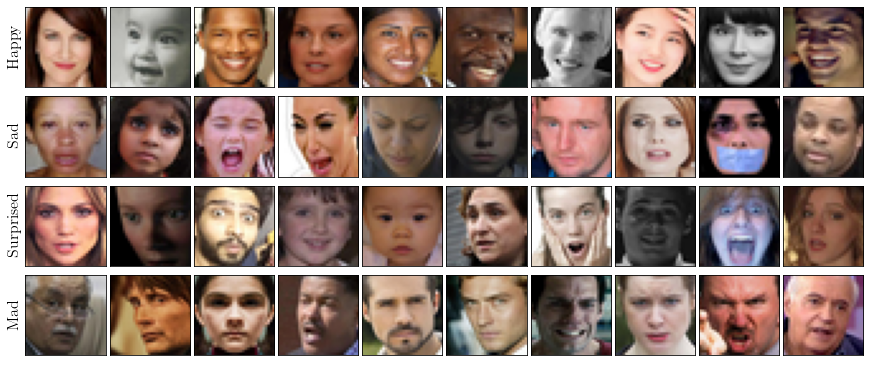

In [4]:
# Plot a few of the training images
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(top=0.995,
                    bottom=0.005,
                    left=0.025,
                    right=0.995,
                    wspace=0.05,
                    hspace=0.0125)
M, N = 4, 10
axs = []
for m in range(M):
    axs.append([])
    for n in range(N):
        ax = plt.subplot2grid((M, N), (m, n), rowspan=1, colspan=1)
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks([])
        axs[m].append(ax)

imgs = []
lbls = []
for epoch in range(3):
    imgs.extend( ((np.array(train_ds[epoch][0]) + 1) / 2) * 255.0)
    #imgs.extend((np.array(train_ds[epoch][0]) * 255.0))
    lbls.extend(train_ds[epoch][1])
indices = [0] * 4
for epoch in range(len(imgs)):
    y = lbls[epoch]
    if indices[y] < N:
        axs[y][indices[y]].imshow(imgs[epoch].astype(int)) # int [0,...,255]
        indices[y] += 1
for m in range(M):
    label = list(train_ds.class_map.keys())[
        list(train_ds.class_map.values()).index(m)]
    axs[m][0].set_ylabel(f"{label}")

In [5]:

def discriminator():
    in_label = tf.keras.layers.Input(shape=(1,))
    
    li = tf.keras.layers.Embedding(NUM_CLASSES, 50)(in_label)
    li = tf.keras.layers.Dense(IMAGE_SHAPE * IMAGE_SHAPE * NUM_PIXEL_CHANNELS)(li)
    li = tf.keras.layers.Reshape(INPUT_SHAPE)(li)
    
    in_image = tf.keras.layers.Input(shape=INPUT_SHAPE)
    
    merge = tf.keras.layers.Concatenate()([in_image, li])

    x = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model([in_image, in_label], out_layer)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    
    return model


def generator():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(NUM_CLASSES, 50)(in_label)

    li = tf.keras.layers.Dense(8*8*NUM_PIXEL_CHANNELS)(li)
    li = tf.keras.layers.Reshape((8, 8, NUM_PIXEL_CHANNELS))(li)

    in_lat = tf.keras.layers.Input(shape=(LATENT_DIM,))
    
    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    x = tf.keras.layers.Dense(n_nodes)(in_lat)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Reshape((8, 8, 128))(x)

    merge = tf.keras.layers.Concatenate()([x, li])
    
    # upsample to 16x16
    x = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    # upsample to 32x32
    x = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    out_layer = tf.keras.layers.Conv2D(NUM_PIXEL_CHANNELS, (3,3), activation='tanh', padding='same')(x)
    model = tf.keras.models.Model([in_lat, in_label], out_layer)
    
    return model


def gan(generator_model, discriminator_model):
    discriminator_model.trainable = False # freez discirminator

    # get noise and label inputs from generator model
    gen_noise, gen_label = generator_model.input
    # get image output from the generator model
    gen_output = generator_model.output

    gan_output = discriminator_model([gen_output, gen_label])
    
    model = tf.keras.models.Model([gen_noise, gen_label], gan_output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

    return model


def get_latent_batch(number_of_samples):
    return [np.random.randn(number_of_samples, LATENT_DIM).reshape(number_of_samples, LATENT_DIM), np.random.randint(0, NUM_CLASSES, number_of_samples)]


def generate_fake_batch(generator_model, number_of_samples):
    x_input, x_labels = get_latent_batch(number_of_samples)
    X = generator_model.predict([x_input, x_labels])
    y = np.zeros((number_of_samples, 1))
    return [X, x_labels], y


def save_plot(images, epoch, n=10):
    plt.figure(figsize=(30, 30))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        image = images[i, :, :, :]
        image = (image + 1) / 2.0
        plt.imshow(image)
    # save plot to file
    file_path = f"./imgs/cGAN_generated_plot_{epoch+1:03d}.png"
    plt.savefig(file_path)
    plt.close()
 

def summarize_performance(epoch, gen_model, disc_model, gan_model, X_real, y_real):
    _, acc_real = disc_model.evaluate([np.array(X_real), np.array(y_real)], np.ones((batch_size, 1)), verbose=0)
    
    [X_fake, X_fake_labels], y_fake = generate_fake_batch(gen_model, batch_size)

    _, acc_fake = disc_model.evaluate([X_fake, X_fake_labels], y_fake, verbose=0)
    
    print(f"Accuracy real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%")
    
    save_plot(X_fake, epoch)

    if True:
        # Save model and waights
        start_epoch = 1
        gen_model.save(f"./models/cGAN_generator_model_{epoch+start_epoch}.h5")
        
        gen_model.save_weights(f"./checkpoints/cGAN_generator_checkpoint_{epoch+start_epoch}.h5")
        disc_model.save_weights(f"./checkpoints/cGAN_discriminator_checkpoint_{epoch+start_epoch}.h5")
        gan_model.save_weights(f"./checkpoints/cGAN_gan_checkpoint_{epoch+start_epoch}.h5")



def prepare_labels(labels, batch_size):
    # Embedding and reshaping the labels to match the image dimensions
    labels = tf.keras.layers.Input(shape=(1,))(labels)
    labels = tf.keras.layers.Embedding(NUM_CLASSES, 50)(labels)
    labels = tf.keras.layers.Dense(IMAGE_SHAPE * IMAGE_SHAPE * NUM_PIXEL_CHANNELS)(labels)
    labels = tf.keras.layers.Reshape((IMAGE_SHAPE, IMAGE_SHAPE, NUM_PIXEL_CHANNELS))(labels)
    return labels

################################################################################################
########################################### TRAINING ###########################################
################################################################################################


VERBOSE_LEVEL = 0
LOAD_MODEL = False
SAVE_INTERVAL = 100

gen_model = generator()
disc_model = discriminator()
gan_model = gan(gen_model, disc_model)

if LOAD_MODEL:
    try:
        checkpoint_num = 169
        gen_model.load_weights(f"./checkpoints/cGAN_generator_checkpoint_{checkpoint_num}.h5")
        disc_model.load_weights(f"./checkpoints/cGAN_discriminator_checkpoint_{checkpoint_num}.h5")
        gan_model.load_weights(f"./checkpoints/cGAN_gan_checkpoint_{checkpoint_num}.h5")
        print("Weights loaded successfully")
    except Exception as e:
        print("Error loading weights:", e)

if VERBOSE_LEVEL > 0:
    disc_model.summary()
    gen_model.summary()
    gan_model.summary()



batch_per_epoch = int(len(train_ds._indices) / batch_size)
for epoch in range(n_epochs):
    for batch_number, (X_real, y_real) in enumerate(train_ds):
        # Train discriminator on real images
        disc_loss_real, _ = disc_model.train_on_batch([np.array(X_real), np.array(y_real)], np.ones((batch_size, 1)))
        # Train discriminator on fake images
        [X_fake, X_fake_labels], y_fake = generate_fake_batch(gen_model, batch_size)
        d_loss_fake, _ = disc_model.train_on_batch([X_fake, X_fake_labels], np.zeros((batch_size, 1)))
        
        # Train cGAN model with latent points
        [X_gan, X_gan_labels] = get_latent_batch(batch_size)
        g_loss = gan_model.train_on_batch([X_gan, X_gan_labels], np.ones((batch_size, 1)))
    
        print(f"Epoch: {epoch+1}/{n_epochs}, Batch: {batch_number+1}/{batch_per_epoch}, Discriminator loss: {(disc_loss_real+d_loss_fake)*0.5}, Generator loss: {g_loss}")
    
    train_ds.on_epoch_end()
    if (epoch+1) % SAVE_INTERVAL == 0:
        summarize_performance(epoch, gen_model, disc_model, gan_model, X_real, y_real)

2024-05-22 11:31:39.892712: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2024-05-22 11:31:39.929022: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3299990000 Hz
2024-05-22 11:31:39.930341: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5605bbe96290 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-22 11:31:39.930353: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-22 11:31:39.935122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 11:31:39.935263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVI

After Embedding: (None, 1, 50)
After Dense: (None, 1, 3072)
After Reshape: (None, 32, 32, 3)
After Merge: (None, 32, 32, 6)


2024-05-22 11:31:45.365783: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-22 11:31:46.204662: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-05-22 11:31:50.066936: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 628.05MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-05-22 11:31:50.343075: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-05-22 11:31:50.343108: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc)

Epoch: 1/10000, Batch: 1/31, Discriminator loss: 0.6943990290164948, Generator loss: 0.6904125809669495
Epoch: 1/10000, Batch: 2/31, Discriminator loss: 0.6559629142284393, Generator loss: 0.6831424236297607
Epoch: 1/10000, Batch: 3/31, Discriminator loss: 0.629495233297348, Generator loss: 0.6708860993385315
Epoch: 1/10000, Batch: 4/31, Discriminator loss: 0.611103430390358, Generator loss: 0.6548928618431091
Epoch: 1/10000, Batch: 5/31, Discriminator loss: 0.5920777022838593, Generator loss: 0.6343316435813904
Epoch: 1/10000, Batch: 6/31, Discriminator loss: 0.5886679291725159, Generator loss: 0.6125661134719849
Epoch: 1/10000, Batch: 7/31, Discriminator loss: 0.5810446739196777, Generator loss: 0.6022025346755981
Epoch: 1/10000, Batch: 8/31, Discriminator loss: 0.5751534998416901, Generator loss: 0.6024932265281677
Epoch: 1/10000, Batch: 9/31, Discriminator loss: 0.5592500865459442, Generator loss: 0.6290484666824341
Epoch: 1/10000, Batch: 10/31, Discriminator loss: 0.52287757396698

KeyboardInterrupt: 

In [ ]:
#model_path = "./model_versions/1000_v1/generator_model_1000.h5"
model_path = "./models/generator_model_150.h5"
gen_model = load_model(model_path)

for i in range(5):
    x_fake, y_fake = generate_fake_batch(gen_model, batch_size)
    save_plot(x_fake, i)